# Model Refinement

![Docent of Perfection](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=414349&type=card)
![Final Iteration](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=414350&type=card)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from model.master_transmuter import *
from model.models import *
from scrape.scraper import *
from query import *
from unit_tests import *

## Adding type, color dummies to features

In [17]:
rarity = 'mythic'
raw_df = pd.read_csv('data/all_vintage_cards-{}_recent.csv'.format(rarity))

# drop sets, drop duplicates, set indices
X, y = csv_cleaner(raw_df)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [18]:
pipe, results_df, model_score = fit_refine_pipeline(X_train, X_test, y_train, y_test)
print('{0} refined features score: {1}'.format(rarity,model_score))

dummy_results_df, baseline_score = baseline_model(X_train, X_test, y_train, y_test)
print('{0} baseline (log mean) score: {1}'.format(rarity,baseline_score))
print('Model improvement over baseline (log mean score): {}'.format(baseline_score-model_score))
print('Worst predicted cards :')
results_df[['cardname','setname','y_pred','y_test','log_diff']].sort_values('log_diff', ascending=False).head(10)

mythic refined features score: 0.8953726564345085
mythic baseline (log mean) score: 0.9701667797036704
Model improvement over baseline (log mean score): 0.0747941232691619
Worst predicted cards :


,cardname,setname,y_pred,y_test,log_diff
id,,,,,
c930c9cc-1b64-4f36-afe2-6bf120a74ce2,"Skithiryx, the Blight Dragon",Scars of Mirrodin,1.3,20.8,2.249001
5d10b752-d9cb-419d-a5c4-d4ee1acb655e,"Teferi, Hero of Dominaria",Dominaria,4.1,47.0,2.241960
c34ae834-775e-447a-a330-0270c227c667,"Atraxa, Praetors' Voice",Commander 2016,2.1,28.0,2.235894
a249be17-73ed-4108-89c0-f7e87939beb8,Craterhoof Behemoth,Avacyn Restored,1.4,17.0,2.014903
224d904a-5972-4152-878a-9a922e7a55b6,"Titania, Protector of Argoth",Commander 2014,1.1,12.9,1.889951
1df70ef3-8919-43ac-9317-23548437a181,"Skysovereign, Consul Flagship",Kaladesh,6.0,0.3,1.683546
d6876c7a-8bbe-484e-b733-70229fa336cd,"Thassa, God of the Sea",Theros,1.2,8.8,1.493925
722b1e02-2268-4e02-8d09-9b337da2a844,Vial Smasher the Fierce,Commander 2016,1.7,11.0,1.491655
62dba377-7446-4517-a504-ee04568fd6cf,All Is Dust,Rise of the Eldrazi,2.9,16.0,1.472237


In [37]:
# Extract feature importances
model = pipe.steps[-1][1]
features = list(pipe.steps[-2][1].train_columns)
feature_importances = np.round(model.feature_importances_,4)

feature_importances = np.array([features, feature_importances]).T
pd.DataFrame(feature_importances[feature_importances[:,1].argsort()[::-1]], columns=['feature','importance'])

,feature,importance
0,cmc:apt,0.1504
1,p:t,0.15
2,cmc,0.14
3,color_intensity,0.0892
4,loyalty,0.069
5,B,0.0538
6,toughness,0.0413
7,avg_pt,0.0408
8,W,0.0401
9,R,0.0392


Observations:

* Planeswalkers harder to predict, possibly due to small sample size to test on, less punishment for missing higher cost cards due to logging (maybe logging y is bad?)

* Legendary creatures, potential commanders unaccounted for

* Expensive spells, creatures punished due to predictive power of cmc

* Creature, Planeswalker have 0 relevance because they are dominated by loyalty and p/t. Rarity also didn't matter because there was only 1. Probably the others with 0 relevance didn't exist in the training set.

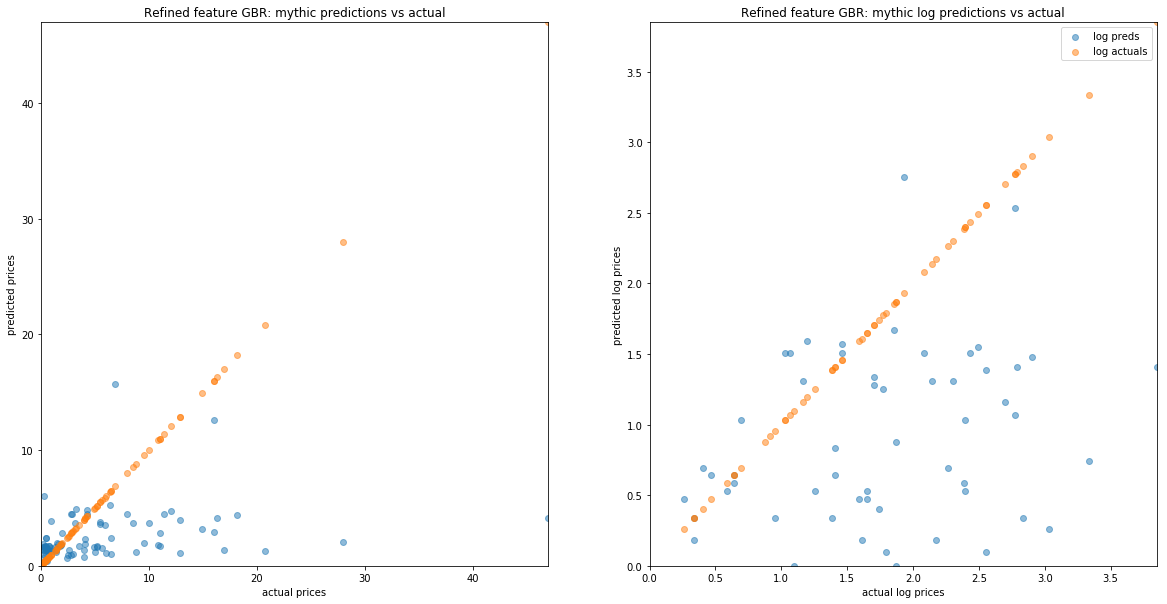

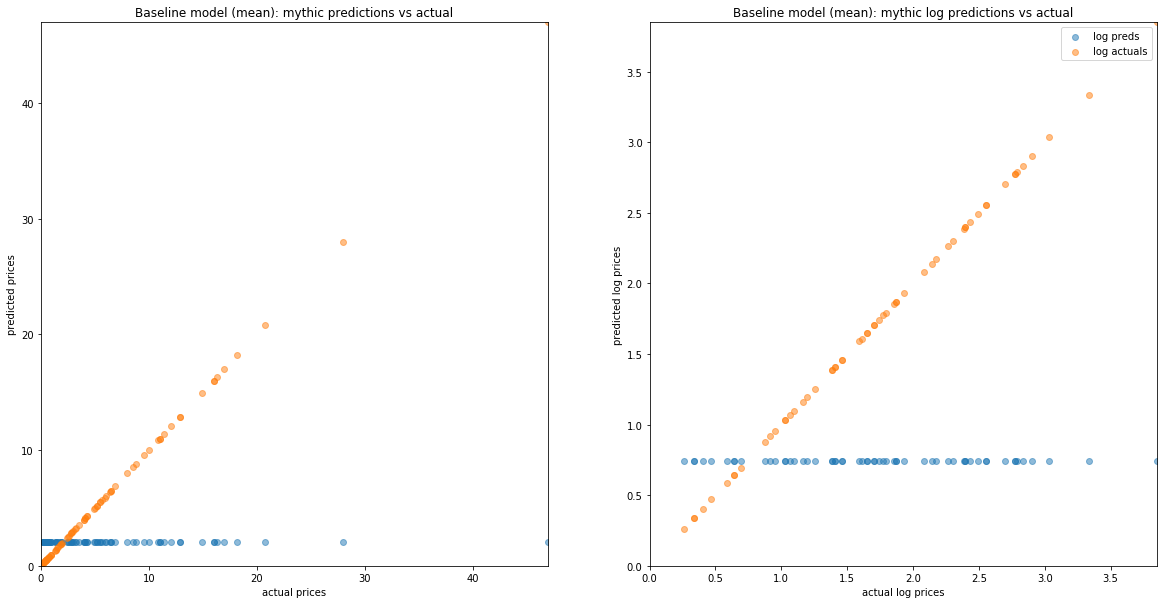

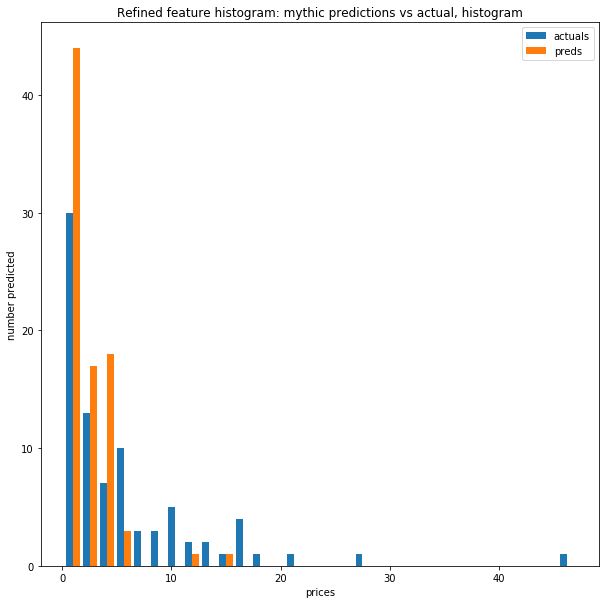

In [19]:
plot_residuals(results_df['y_pred'],results_df['y_test'], 'Refined feature GBR: '+rarity)
plot_residuals(dummy_results_df['y_pred'],dummy_results_df['y_test'], 'Baseline model (mean): '+rarity)
plot_pred_hist(results_df['y_pred'],results_df['y_test'], 'Refined feature histogram: '+rarity)

## Retry excluding commander

In [38]:
rarity = 'mythic'
raw_df = pd.read_csv('data/all_vintage_cards-{}_recent.csv'.format(rarity))

# drop sets, drop duplicates, set indices
X, y = csv_cleaner(raw_df)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

pipe, results_df, model_score = fit_refine_pipeline(X_train, X_test, y_train, y_test)
print('{0} refined features score: {1}'.format(rarity,model_score))

dummy_results_df, baseline_score = baseline_model(X_train, X_test, y_train, y_test)
print('{0} baseline (log mean) score: {1}'.format(rarity,baseline_score))
print('Model improvement over baseline (log mean score): {}'.format(baseline_score-model_score))
print('Worst predicted cards :')
results_df[['cardname','setname','y_pred','y_test','log_diff']].sort_values('log_diff', ascending=False).head(10)

mythic refined features score: 0.9121654086305591
mythic baseline (log mean) score: 0.9099424611259677
Model improvement over baseline (log mean score): -0.0022229475045913993
Worst predicted cards :


,cardname,setname,y_pred,y_test,log_diff
id,,,,,
c930c9cc-1b64-4f36-afe2-6bf120a74ce2,"Skithiryx, the Blight Dragon",Scars of Mirrodin,1.0,20.8,2.388763
5d10b752-d9cb-419d-a5c4-d4ee1acb655e,"Teferi, Hero of Dominaria",Dominaria,3.8,47.0,2.302585
daccec32-84c6-4de4-9b00-c497a6ba5de8,Rekindling Phoenix,Rivals of Ixalan,2.5,29.0,2.148434
a01f829b-22aa-4988-9698-5e1ebceb1dd8,Scourge of the Throne,Conspiracy,1.6,17.4,1.956839
ba149706-cd17-4da6-8403-ccfe2d6cb437,"Avacyn, Angel of Hope",Avacyn Restored,2.3,16.9,1.690878
51eb9f05-9d5a-4196-9329-626ce4793c42,Vengevine,Rise of the Eldrazi,3.6,23.5,1.672617
fbf60d69-fc68-4b23-a9e8-9d310c00a865,Lord of Extinction,Alara Reborn,1.3,10.2,1.583005
8d171b46-69e7-4e39-b3b2-97ed022cd933,Chromanticore,Born of the Gods,7.1,0.7,1.561236
7f3423d7-cb81-47bf-b9a6-a279ba6cedf4,Phyrexian Scriptures,Dominaria,9.9,1.3,1.555854


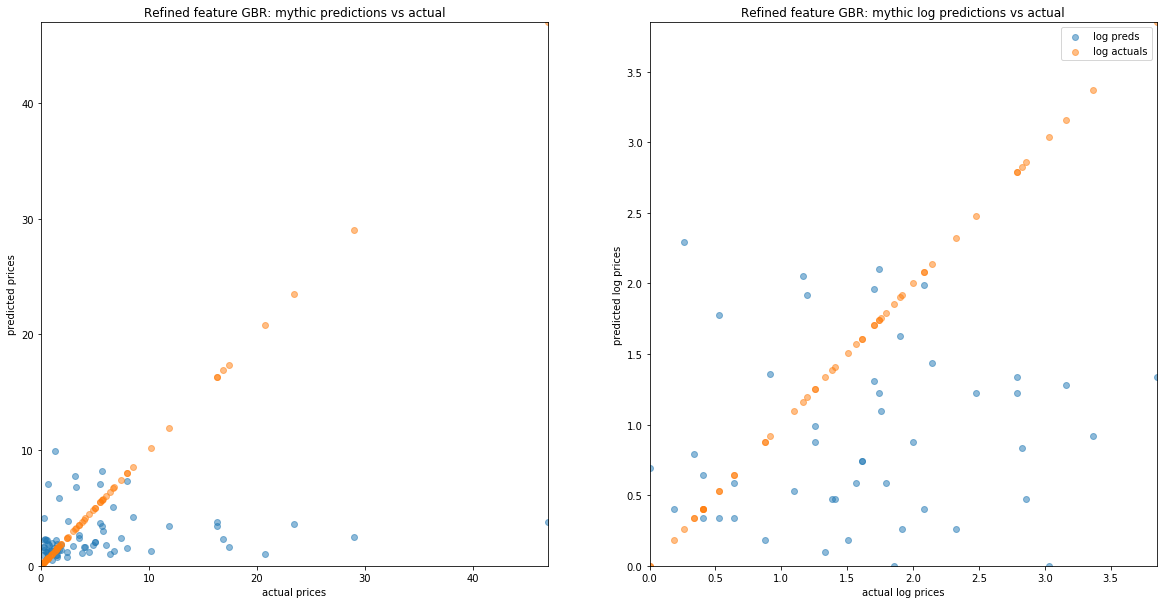

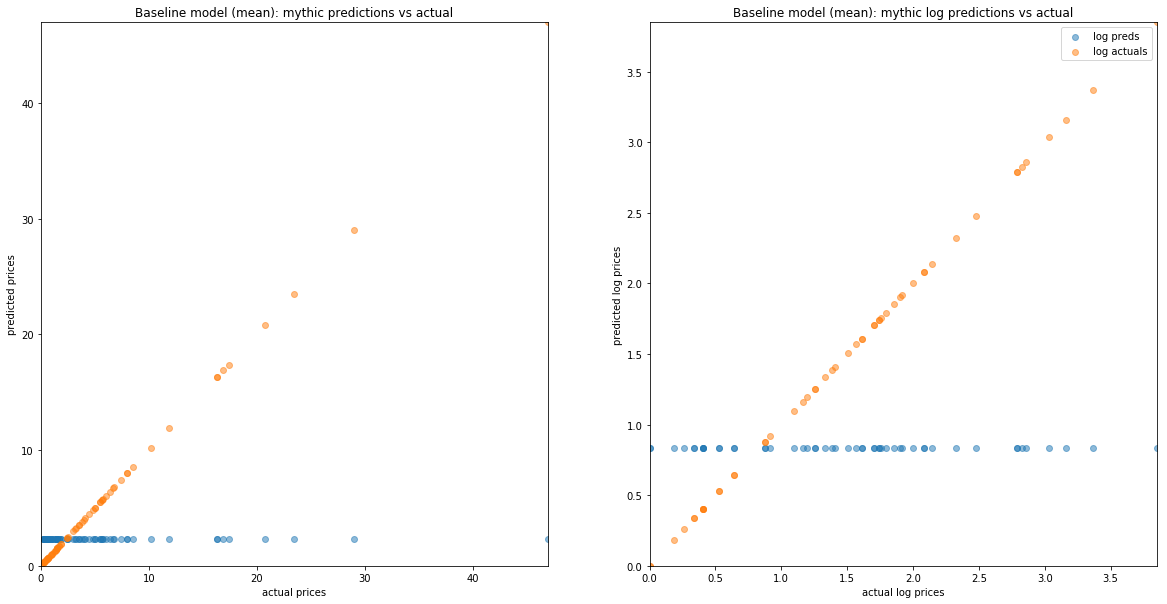

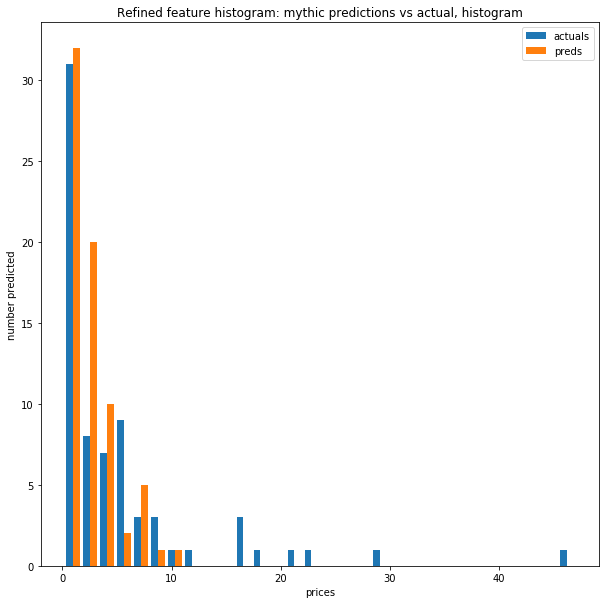

In [39]:
# Extract feature importances
model = pipe.steps[-1][1]
features = list(pipe.steps[-2][1].train_columns)
feature_importances = model.feature_importances_

feature_importances = np.array([features, feature_importances]).T
feature_importances[feature_importances[:,1].argsort()[::-1]]

# Plot residuals
plot_residuals(results_df['y_pred'],results_df['y_test'], 'Refined feature GBR: '+rarity)
plot_residuals(dummy_results_df['y_pred'],dummy_results_df['y_test'], 'Baseline model (mean): '+rarity)
plot_pred_hist(results_df['y_pred'],results_df['y_test'], 'Refined feature histogram: '+rarity)

Score got worse :( Try adding Legendary dummifier

## +Legendary Dummifier, +Commander Back In

In [46]:
# drop sets, drop duplicates, set indices
X, y = csv_cleaner(raw_df)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

pipe, results_df, model_score = fit_refine_pipeline(X_train, X_test, y_train, y_test)
print('{0} refined features score: {1}'.format(rarity,model_score))

dummy_results_df, baseline_score = baseline_model(X_train, X_test, y_train, y_test)
print('{0} baseline (log mean) score: {1}'.format(rarity,baseline_score))
print('Model improvement over baseline (log mean score): {}'.format(baseline_score-model_score))
print('Worst predicted cards :')
results_df[['cardname','setname','y_pred','y_test','log_diff']].sort_values('log_diff', ascending=False).head(10)

mythic refined features score: 0.8850789367347449
mythic baseline (log mean) score: 0.9701667797036704
Model improvement over baseline (log mean score): 0.08508784296892546
Worst predicted cards :


,cardname,setname,y_pred,y_test,log_diff
id,,,,,
c34ae834-775e-447a-a330-0270c227c667,"Atraxa, Praetors' Voice",Commander 2016,1.9,28.0,2.302585
5d10b752-d9cb-419d-a5c4-d4ee1acb655e,"Teferi, Hero of Dominaria",Dominaria,4.0,47.0,2.261763
c930c9cc-1b64-4f36-afe2-6bf120a74ce2,"Skithiryx, the Blight Dragon",Scars of Mirrodin,1.7,20.8,2.088658
a249be17-73ed-4108-89c0-f7e87939beb8,Craterhoof Behemoth,Avacyn Restored,1.3,17.0,2.057463
224d904a-5972-4152-878a-9a922e7a55b6,"Titania, Protector of Argoth",Commander 2014,1.2,12.9,1.843431
1df70ef3-8919-43ac-9317-23548437a181,"Skysovereign, Consul Flagship",Kaladesh,4.9,0.3,1.512588
425b3c5b-de65-46b2-b26d-347cc31beb4c,Maelstrom Nexus,Alara Reborn,1.9,11.0,1.420196
d6876c7a-8bbe-484e-b733-70229fa336cd,"Thassa, God of the Sea",Theros,1.4,8.8,1.406914
62dba377-7446-4517-a504-ee04568fd6cf,All Is Dust,Rise of the Eldrazi,3.2,16.0,1.398129


In [49]:
# Extract feature importances
model = pipe.steps[-1][1]
features = list(pipe.steps[-2][1].train_columns)
feature_importances = np.round(model.feature_importances_,4)

feature_importances = np.array([features, feature_importances]).T
pd.DataFrame(feature_importances[feature_importances[:,1].argsort()[::-1]], columns=['feature','importance'])

,feature,importance
0,cmc,0.1517
1,p:t,0.1403
2,cmc:apt,0.1336
3,color_intensity,0.0966
4,avg_pt,0.0588
5,loyalty,0.0512
6,B,0.0466
7,power,0.0448
8,Legendary,0.0386
9,toughness,0.0271


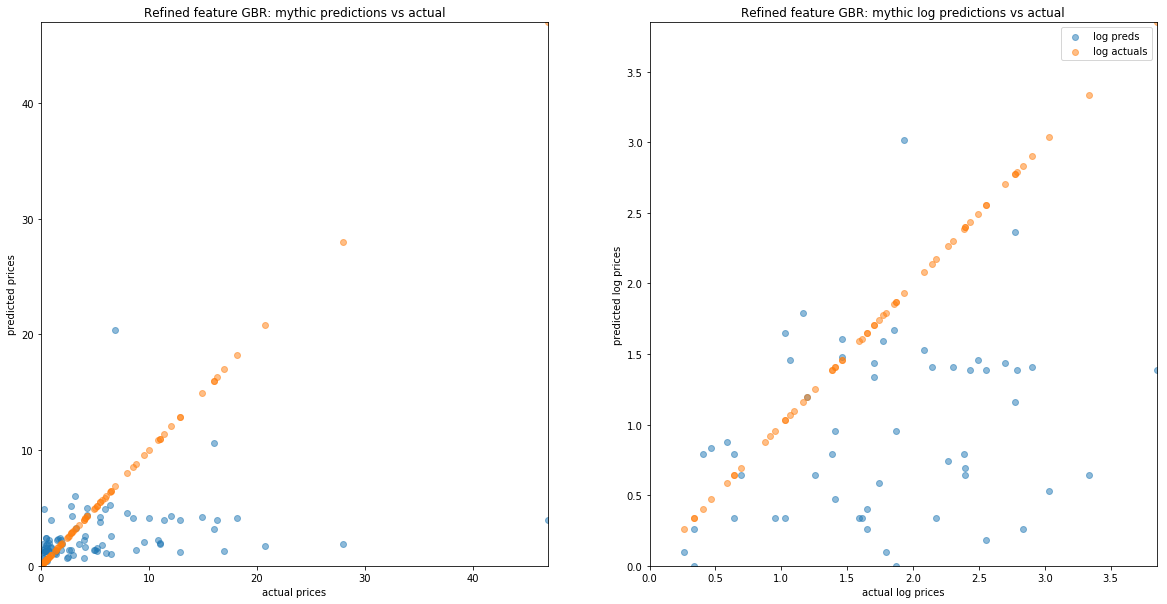

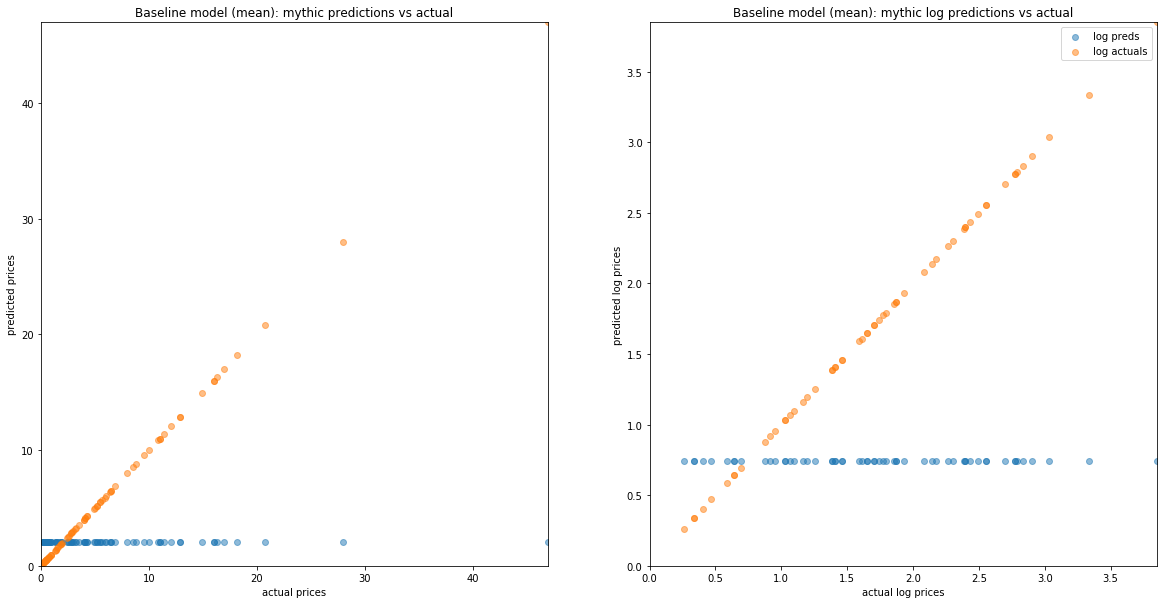

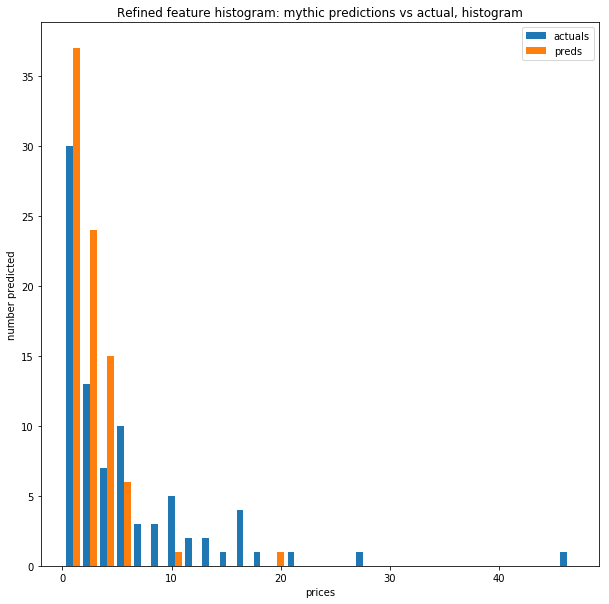

In [48]:
# Plot residuals
plot_residuals(results_df['y_pred'],results_df['y_test'], 'Refined feature GBR: '+rarity)
plot_residuals(dummy_results_df['y_pred'],dummy_results_df['y_test'], 'Baseline model (mean): '+rarity)
plot_pred_hist(results_df['y_pred'],results_df['y_test'], 'Refined feature histogram: '+rarity)

## Start of Textual Analysis

### Ability Counts

In [55]:
# Activated Abilities
raw_df['oracle_text'][0].count(':')

3

In [61]:
list(raw_df['oracle_text'][1:4])

['+2: Untap up to one target artifact or creature.\r\r\n−3: You gain 2 life and draw two cards.\r\r\n−9: Take an extra turn after this one.',
 'Flying\r\r\nWhenever Weatherlight deals combat damage to a player, look at the top five cards of your library. You may reveal a historic card from among them and put it into your hand. Put the rest on the bottom of your library in a random order. (Artifacts, legendaries, and Sagas are historic.)\r\r\nCrew 3',
 '{T}: Add one mana of any color among legendary creatures and planeswalkers you control.',
 '+1: Draw a card. At the beginning of the next end step, untap up to two lands.\r\r\n−3: Put target nonland permanent into its owner\'s library third from the top.\r\r\n−8: You get an emblem with "Whenever you draw a card, exile target permanent an opponent controls."',
 'During each of your turns, you may play up to one permanent card of each permanent type from your graveyard. (If a card has multiple permanent types, choose one as you play it.)',

In [69]:
list(raw_df[raw_df['cardname']=='Carnage Tyrant']['oracle_text'])[0]

"This spell can't be countered.\r\r\nTrample, hexproof"

In [71]:
# Ability lines
raw_df['oracle_text'][0].split('\r\r\n')

['+1: Add {R}{R}. Chandra, Bold Pyromancer deals 2 damage to target player.',
 '−3: Chandra, Bold Pyromancer deals 3 damage to target creature or planeswalker.',
 '−7: Chandra, Bold Pyromancer deals 10 damage to target player and each creature and planeswalker they control.']

In [72]:
list(raw_df[raw_df['cardname']=='Carnage Tyrant']['oracle_text'])[0].split('\r\r\n')

["This spell can't be countered.", 'Trample, hexproof']

In [73]:
len(list(raw_df[raw_df['cardname']=='Carnage Tyrant']['oracle_text'])[0].split('\r\r\n'))

2

In [83]:
'When' in raw_df['oracle_text'][6] or 'At' in raw_df['oracle_text'][6]

True

In [84]:
raw_df['oracle_text'][6].count('When')

1

In [90]:
raw_df['oracle_text'][7]

'Flying, trample, haste\r\r\nIf Darigaaz Reincarnated would die, instead exile it with three egg counters on it.\r\r\nAt the beginning of your upkeep, if Darigaaz is exiled with an egg counter on it, remove an egg counter from it. Then if Darigaaz has no egg counters on it, return it to the battlefield.'

In [91]:
len(re.findall('When|At',raw_df['oracle_text'][7]))

['At']

In [92]:
'hello'.count('a')

0

In [94]:
abilities = AbilityCountsTransformer()
able_df = abilities.transform(raw_df)
able_df.head()

,Unnamed: 0,id,cardname,setname,type_line,mana_cost,rarity,oracle_text,power,toughness,...,color_identity,colors,reprint,layout,legalities,timestamp,price,ability_sects,activated,triggered
0,0,ba9d2384-5c3f-4eb1-86b4-26ee13f1c767,"Chandra, Bold Pyromancer",Dominaria,Legendary Planeswalker — Chandra,{4}{R}{R},mythic,"+1: Add {R}{R}. Chandra, Bold Pyromancer deals...",NaN,NaN,...,['R'],['R'],False,normal,"{'standard': 'legal', 'future': 'legal', 'fron...",1541350580379,5.0,3,3,0
1,1,eb2b7388-ac6b-45c0-a5cc-da6450724b59,"Teferi, Timebender",Dominaria,Legendary Planeswalker — Teferi,{4}{W}{U},mythic,+2: Untap up to one target artifact or creatur...,NaN,NaN,...,"['U', 'W']","['U', 'W']",False,normal,"{'standard': 'legal', 'future': 'legal', 'fron...",1542041780379,5.0,3,3,0
2,2,d4581fc0-551c-4ee5-bde0-65c2b8cdf1b7,Weatherlight,Dominaria,Legendary Artifact — Vehicle,{4},mythic,Flying\r\r\nWhenever Weatherlight deals combat...,4,5,...,[],[],False,normal,"{'standard': 'legal', 'future': 'legal', 'fron...",1542041780377,0.5,3,0,1
3,3,66024e69-ad60-4c9a-a0ca-da138d33ad80,Mox Amber,Dominaria,Legendary Artifact,{0},mythic,{T}: Add one mana of any color among legendary...,NaN,NaN,...,[],[],False,normal,"{'standard': 'legal', 'future': 'legal', 'fron...",1542041780376,6.8,1,1,0
4,4,5d10b752-d9cb-419d-a5c4-d4ee1acb655e,"Teferi, Hero of Dominaria",Dominaria,Legendary Planeswalker — Teferi,{3}{W}{U},mythic,+1: Draw a card. At the beginning of the next ...,NaN,NaN,...,"['U', 'W']","['U', 'W']",False,normal,"{'standard': 'legal', 'future': 'legal', 'fron...",1542041780374,47.0,3,3,2


## Test Model Improvement with Naive Ability Featurization (NAF)

In [128]:
rarity = 'mythic'
raw_df = pd.read_csv('data/all_vintage_cards-{}_recent.csv'.format(rarity))

# drop sets, drop duplicates, set indices
X, y = csv_cleaner(raw_df)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

pipe, results_df, model_score = fit_refine_pipeline(X_train, X_test, y_train, y_test)
print('{0} refined features score: {1}'.format(rarity,model_score))

dummy_results_df, baseline_score = baseline_model(X_train, X_test, y_train, y_test)
print('{0} baseline (log mean) score: {1}'.format(rarity,baseline_score))
print('Model improvement over baseline (log mean score): {}'.format(baseline_score-model_score))
print('Worst predicted cards :')
results_df[['cardname','setname','y_pred','y_test','log_diff']].sort_values('log_diff', ascending=False).head(10)

mythic refined features score: 0.8856438881581485
mythic baseline (log mean) score: 0.9701667797036704
Model improvement over baseline (log mean score): 0.08452289154552184
Worst predicted cards :


,cardname,setname,y_pred,y_test,log_diff
id,,,,,
c34ae834-775e-447a-a330-0270c227c667,"Atraxa, Praetors' Voice",Commander 2016,1.7,28.0,2.374044
c930c9cc-1b64-4f36-afe2-6bf120a74ce2,"Skithiryx, the Blight Dragon",Scars of Mirrodin,1.1,20.8,2.339973
5d10b752-d9cb-419d-a5c4-d4ee1acb655e,"Teferi, Hero of Dominaria",Dominaria,3.9,47.0,2.281966
a249be17-73ed-4108-89c0-f7e87939beb8,Craterhoof Behemoth,Avacyn Restored,0.9,17.0,2.248518
62dba377-7446-4517-a504-ee04568fd6cf,All Is Dust,Rise of the Eldrazi,1.9,16.0,1.768503
722b1e02-2268-4e02-8d09-9b337da2a844,Vial Smasher the Fierce,Commander 2016,1.6,11.0,1.529395
224d904a-5972-4152-878a-9a922e7a55b6,"Titania, Protector of Argoth",Commander 2014,2.2,12.9,1.468738
7bf6baf2-d20b-467d-8929-abefcf7dfa99,"Purphoros, God of the Forge",Theros,2.7,14.9,1.457986
021f57dc-80f3-4ede-99d5-4a44aade44e2,Star of Extinction,Ixalan,0.8,6.5,1.427116


In [129]:
# Extract feature importances
model = pipe.steps[-1][1]
features = list(pipe.steps[-2][1].train_columns)
feature_importances = np.round(model.feature_importances_,4)

feature_importances = np.array([features, feature_importances]).T
pd.DataFrame(feature_importances[feature_importances[:,1].argsort()[::-1]], columns=['feature','importance'])

,feature,importance
0,cmc:apt,0.1386
1,p:t,0.1011
2,cmc,0.0855
3,triggered,0.0847
4,color_intensity,0.0602
5,ability_sects,0.0558
6,loyalty,0.0414
7,Legendary,0.0399
8,activated,0.0385
9,avg_pt,0.0359


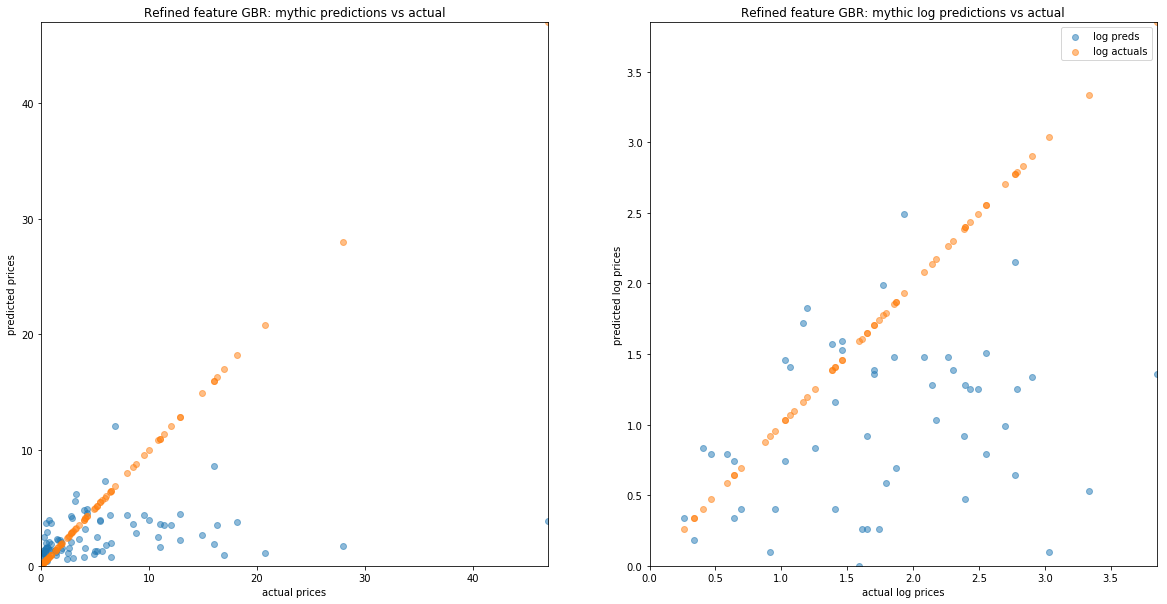

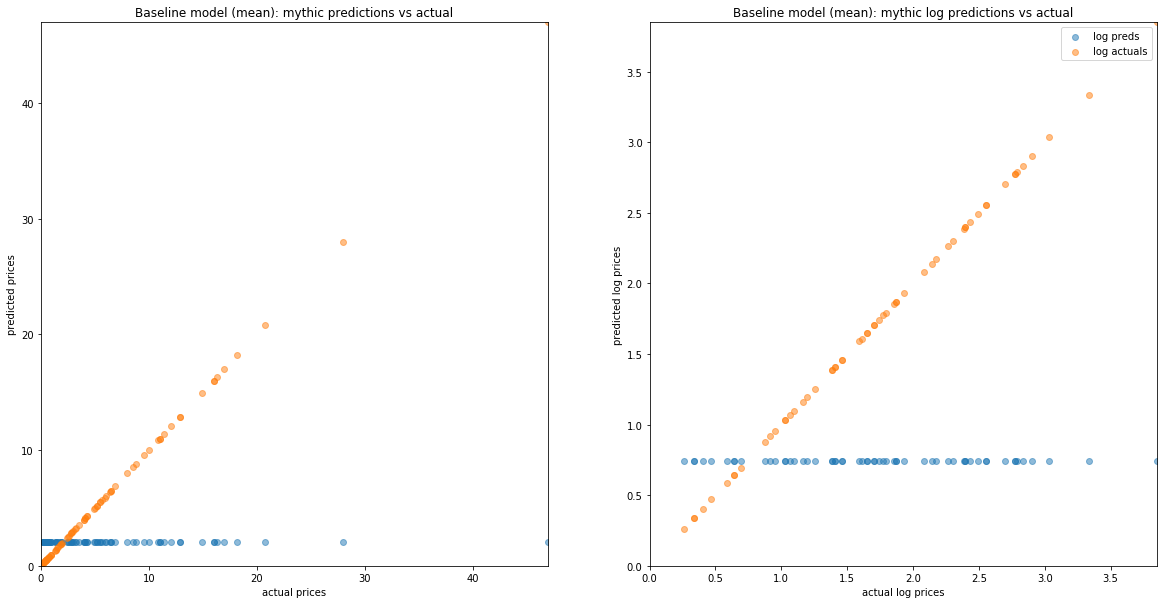

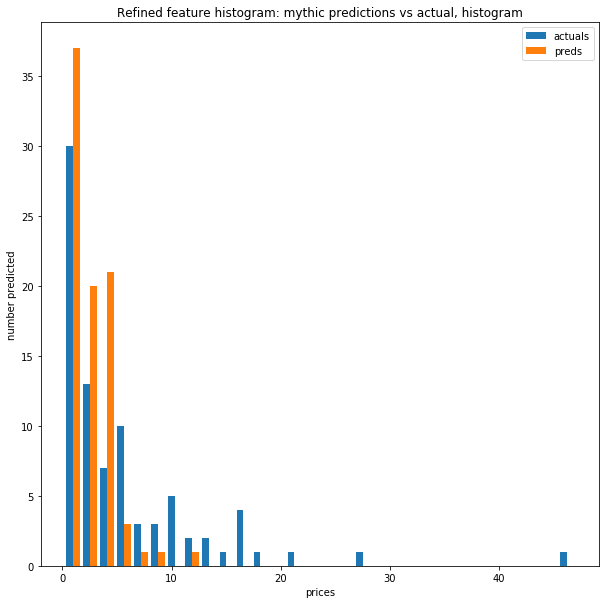

In [130]:
# Plot residuals
plot_residuals(results_df['y_pred'],results_df['y_test'], 'Refined feature GBR: '+rarity)
plot_residuals(dummy_results_df['y_pred'],dummy_results_df['y_test'], 'Baseline model (mean): '+rarity)
plot_pred_hist(results_df['y_pred'],results_df['y_test'], 'Refined feature histogram: '+rarity)

Observations:

* Planeswalkers, expensive spells, and commander cards are still hard to predict. Might be better once 
* All of the added ability features seem to matter, as does the legendary type (possibly picking up on commander signal?). There is potential for overfitting here as well, as I add more and more features.

Questions:

* Do I want to keep using log error? Or would it be better to fit to the prices directly?
* Direct fit will give me better performance on expensive cards, and worse on cheaper ones. 
* How do I account for big spells / creatures, and planeswalkers? Maybe loyalty costs and ngramming will help. N-Grams like "destroy all" could be particularly useful

## Let's try on rares now

In [132]:
rarity = 'rare'
raw_df = pd.read_csv('data/all_vintage_cards-{}_recent.csv'.format(rarity))

# drop sets, drop duplicates, set indices
X, y = csv_cleaner(raw_df)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

pipe, results_df, model_score = fit_refine_pipeline(X_train, X_test, y_train, y_test)
print('{0} refined features score: {1}'.format(rarity,model_score))

dummy_results_df, baseline_score = baseline_model(X_train, X_test, y_train, y_test)
print('{0} baseline (log mean) score: {1}'.format(rarity,baseline_score))
print('Model improvement over baseline (log mean score): {}'.format(baseline_score-model_score))
print('Worst predicted cards :')
results_df[['cardname','setname','y_pred','y_test','log_diff']].sort_values('log_diff', ascending=False).head(10)

rare refined features score: 0.6741362890880944
rare baseline (log mean) score: 0.78262738087587
Model improvement over baseline (log mean score): 0.1084910917877756
Worst predicted cards :


,cardname,setname,y_pred,y_test,log_diff
id,,,,,
1381c8f1-a292-4bdf-b20c-a5c2a169ee84,Cavern of Souls,Avacyn Restored,1.2,56.0,3.254594
0a07cba3-2e8d-48ec-a6f8-4d2edfcd833d,Vampiric Tutor,Visions,1.1,45.8,3.103946
7f89a173-0b2f-4a6a-b706-9aed8dbcabec,Oracle of Mul Daya,Zendikar,0.7,27.7,2.826269
c8173030-1c33-417c-b8e9-79231b6a85a7,Recurring Nightmare,Exodus,0.7,26.8,2.794408
92b45f79-f23e-4eef-8cac-91780dc2a044,Runed Halo,Shadowmoor,0.8,22.0,2.547708
dafea0d1-6986-46b3-affc-1337ef564947,Primal Vigor,Commander 2013,0.7,17.0,2.359744
d465597a-362e-4bd0-b547-f11d8807e597,Trinisphere,Darksteel,1.4,23.0,2.302585
3b6e5956-f795-451b-bb24-56462d1ced27,Umezawa's Jitte,Betrayers of Kamigawa,1.1,19.3,2.268684
72e4548b-c171-4f10-b896-af37543dcf0f,Marrow-Gnawer,Champions of Kamigawa,1.0,16.5,2.169054


In [135]:
results_df[['cardname','setname','y_pred','y_test','log_diff']].sort_values('log_diff', ascending=True).head(10)

,cardname,setname,y_pred,y_test,log_diff
id,,,,,
7db86e34-c3ec-4a29-8779-81350a985644,Destructive Flow,Planeshift,0.4,0.4,0.0
e26b31ce-416f-4309-b591-798cf12175af,Mirror Sheen,Eventide,0.5,0.5,0.0
5852f528-92aa-45cf-8436-5774691676d3,Bogardan Hellkite,Time Spiral,0.5,0.5,0.0
15a31710-c1d6-45e4-9dbe-a75453a74da0,Cryptoplasm,Mirrodin Besieged,0.7,0.7,0.0
3223610b-7a87-42c1-a6cc-b5f249ca8cb9,"Alesha, Who Smiles at Death",Commander 2016,0.4,0.4,0.0
5fb66439-df73-4a01-a8d4-6f2334297fdf,Spirit of Resistance,Invasion,0.8,0.8,0.0
201a7054-e4e8-4e5a-a002-319fcd210994,Crown of Doom,Commander 2014,0.7,0.7,0.0
43b5bd60-87ed-41d2-bbcb-bd4a40a772c9,Tide of War,Champions of Kamigawa,0.5,0.5,0.0
e75bdab4-9507-47e7-bf70-f78c87d2e0ba,Mystic Snake,Commander 2015,0.6,0.6,0.0


In [133]:
# Extract feature importances
model = pipe.steps[-1][1]
features = list(pipe.steps[-2][1].train_columns)
feature_importances = np.round(model.feature_importances_,4)

feature_importances = np.array([features, feature_importances]).T
pd.DataFrame(feature_importances[feature_importances[:,1].argsort()[::-1]], columns=['feature','importance'])

,feature,importance
0,cmc,0.1371
1,ability_sects,0.0892
2,activated,0.0723
3,cmc:apt,0.0663
4,mana_abilities,0.0522
5,Legendary,0.0507
6,triggered,0.0464
7,avg_pt,0.0438
8,p:t,0.0424
9,power,0.0418


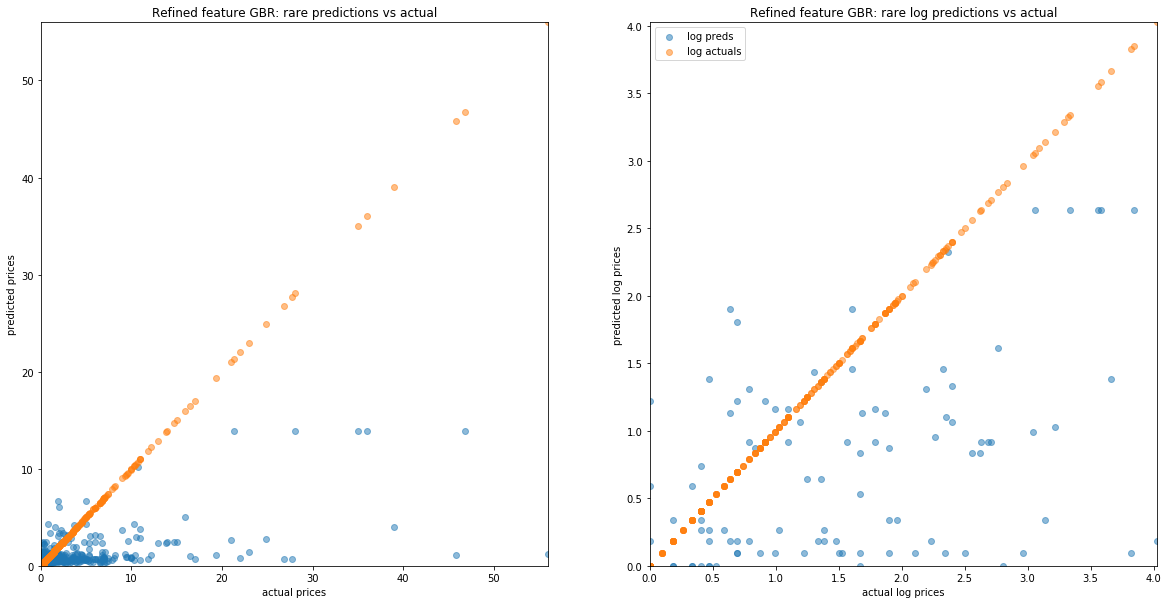

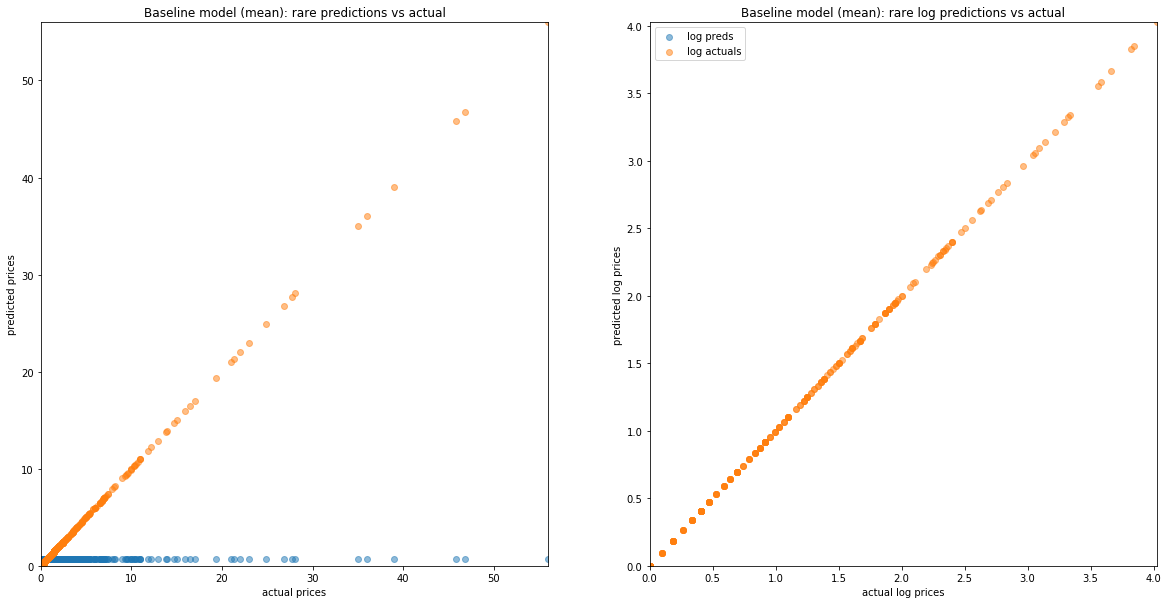

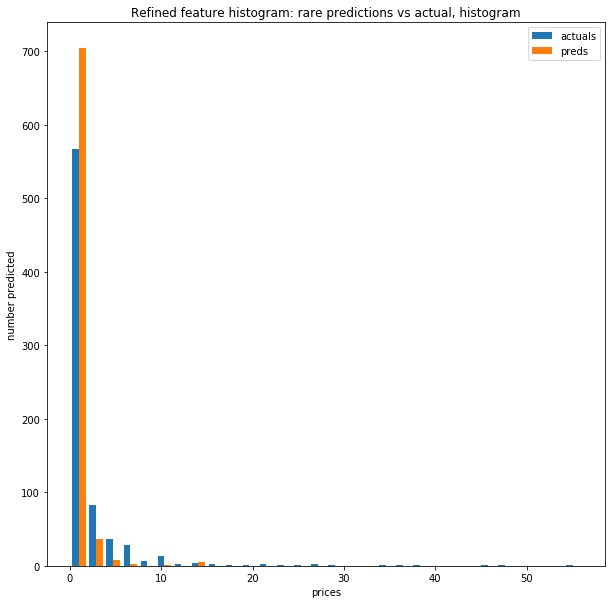

In [134]:
# Plot residuals
plot_residuals(results_df['y_pred'],results_df['y_test'], 'Refined feature GBR: '+rarity)
plot_residuals(dummy_results_df['y_pred'],dummy_results_df['y_test'], 'Baseline model (mean): '+rarity)
plot_pred_hist(results_df['y_pred'],results_df['y_test'], 'Refined feature histogram: '+rarity)